In [69]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
import scipy.stats as stats

# Vector outputs GPs

## Example with 2 dependent series

INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


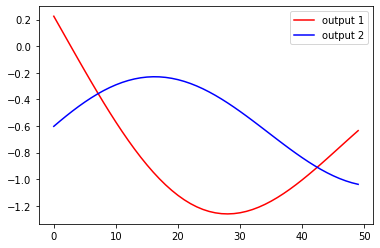

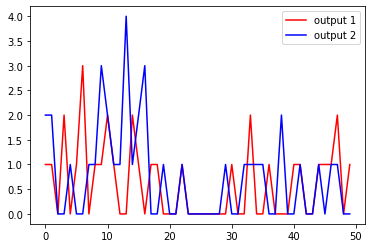

In [190]:
np.random.seed(20)

n=100
t = np.linspace(0, n, n)[:,None]
output_1 = np.ones((int(n/2), 1))
output_2 = 2*np.ones((int(n/2), 1))
X = np.hstack((t, np.vstack((output_1, output_2))))

#ls = np.array([0.2, 1.0])
l1=30.0;l2=100
eta = 1
# l1 is lengthscale of variation over t
# l2 gives similarity between output1 and output2
cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1, l2])
K = cov(X).eval()

# draw 1 sample from GP prior with mean zero
y_ = pm.MvNormal.dist(mu=np.zeros(n), cov=K).random(size=1)

y = pm.Poisson.dist(np.exp(y_)).random(size=1)

plt.plot(np.arange(n/2), y_.T[:int(n/2)], 'r', label="output 1");
plt.plot(np.arange(n/2), y_.T[int(n/2):], 'b', label="output 2");
plt.legend()
plt.show()

plt.plot(np.arange(n/2), y.T[:int(n/2)], 'r', label="output 1");
plt.plot(np.arange(n/2), y.T[int(n/2):], 'b', label="output 2");
plt.legend()
plt.show();

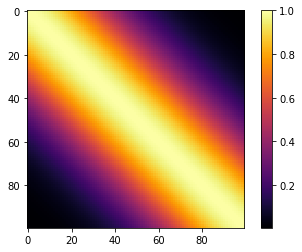

In [192]:
# A big l2 gives a high correlation between series

#ls = np.array([0.2, 1.0])
l1=30.0;l2=100
eta = 1
# l1 is lengthscale of variation over t
# l2 gives similarity between output1 and output2
cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1, l2])
K = cov(X).eval()
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


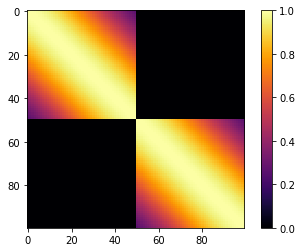

In [194]:
# A small l2 gives a low correlation between series

#ls = np.array([0.2, 1.0])
l1=30.0;l2=0.1
eta = 1
# l1 is lengthscale of variation over t
# l2 gives similarity between output1 and output2
cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1, l2])
K = cov(X).eval()
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

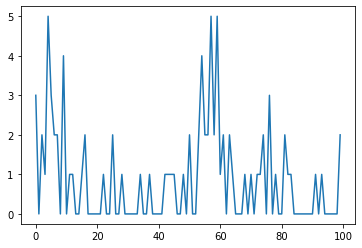

In [38]:
plt.plot(y.T);

INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


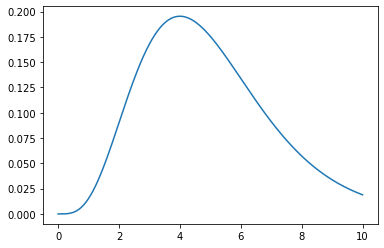

In [199]:
# Check prior for l
x = np.linspace(0, 10, 500)
plt.plot(x, np.exp(pm.Gamma.dist(alpha=5, beta=1).logp(x).eval()));

In [200]:
with pm.Model() as model_comp:
    #hyper-parameter priors
    l = pm.Gamma('l', alpha=5, beta=1, shape=2)   
    #eta = pm.HalfCauchy('eta', beta=3)
    cov_func = pm.gp.cov.ExpQuad(2, l)

    #Gaussian Process
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)

    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y.T)

In [201]:
with model:
    trace_comp = (draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, l]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 1981 seconds.
INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


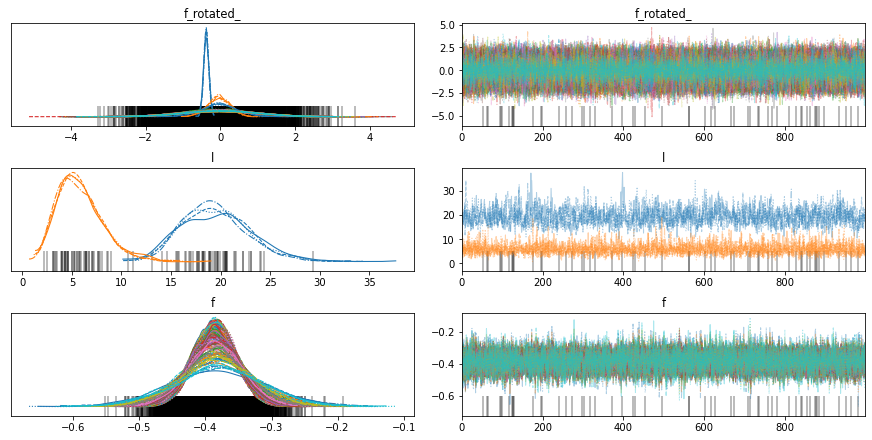

In [202]:
with model:
    pm.traceplot(trace_comp);

In [203]:
pm.summary(trace_comp, var_names=['~f_rotated_', '~f'])

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
l[0],19.497,3.439,13.266,25.833,0.097,0.069,1260.0,1260.0,1266.0,1984.0,1.0
l[1],5.826,2.301,1.969,10.088,0.032,0.024,5020.0,4633.0,4809.0,3042.0,1.0


In [204]:
#ls = np.array([0.2, 1.0])
n = 100
it = 50
l1=trace_comp['l'][0:it,0];l2=trace_comp['l'][0:it,1]
eta = 1

y_gp = np.zeros((n,it))
y_pred = np.zeros((n, it))
for i in range(it):
    # l1 is lengthscale of variation over t, l2 gives similarity between output1 and output2
    cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1[i], l2[i]])
    K = cov(X).eval()

    # draw 1 sample from GP prior with mean zero
    y_gp[:,i] = pm.MvNormal.dist(mu=np.zeros(100), cov=K).random(size=1)

    y_pred[:,i] = pm.Poisson.dist(np.exp(y_)).random(size=1)

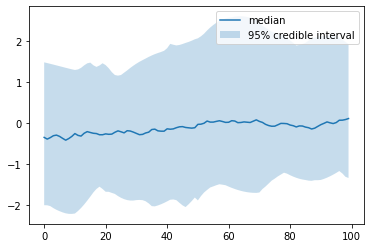

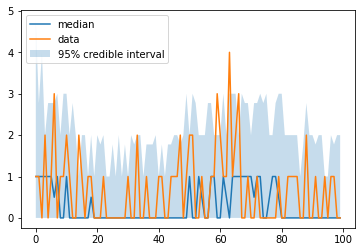

In [210]:
#y_gp_q = np.percentile(y_gp, axis=1, q=[2.5, 50, 97.5])
#plt.plot(np.arange(n), y_gp_q[1], label='median')
#plt.fill_between(np.arange(n), y_gp_q[0], y_gp_q[2],
#                alpha=0.25, label='95% credible interval')
#plt.legend()
#plt.show()

y_pred_q = np.percentile(y_pred, axis=1, q=[2.5, 50, 97.5])
plt.plot(np.arange(n), y_pred_q[1], label='median')
plt.fill_between(np.arange(n), y_pred_q[0], y_pred_q[2],
                alpha=0.25, label='95% credible interval')
plt.plot(np.arange(n),y.T, label='data')
plt.legend()
plt.show()

# Different size inputs

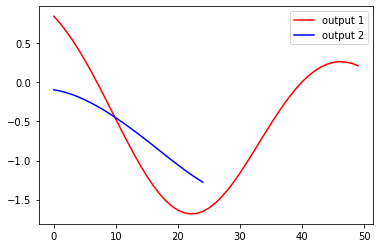

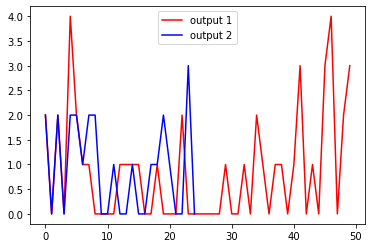

In [311]:
np.random.seed(20)

n=100
t = np.arange(n*3/4)[:,None]
output_1 = np.ones((int(n/2), 1))
output_2 = 2*np.ones((int(n/4), 1))
X = np.hstack((t, np.vstack((output_1, output_2))))

#ls = np.array([0.2, 1.0])
l1=15.0;l2=2.
eta = 1
# l1 is lengthscale of variation over t
# l2 gives similarity between output1 and output2
cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1, l2])
K = cov(X).eval()

# draw 1 sample from GP prior with mean zero
y_ = pm.MvNormal.dist(mu=np.zeros(int(n/2) + int(n/4)), cov=K).random(size=1)

y = pm.Poisson.dist(np.exp(y_)).random(size=1)


plt.plot(np.arange(n/2), y_.T[:int(n/2)], 'r', label="output 1");
plt.plot(np.arange(n/4), y_.T[int(n/2):], 'b', label="output 2");
plt.legend()
plt.show()

plt.plot(np.arange(n/2), y.T[:int(n/2)], 'r', label="output 1");
plt.plot(np.arange(n/4), y.T[int(n/2):], 'b', label="output 2");
plt.legend()
plt.show();

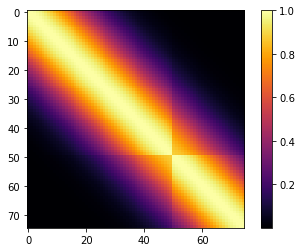

In [312]:
cov = eta**2 * pm.gp.cov.ExpQuad(2, [l1, l2])
K = cov(X).eval()
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

In [313]:
with pm.Model() as model_part:
    #hyper-parameter priors
    l = pm.Gamma('l', alpha=2, beta=2, shape=2)   
    #eta = pm.HalfCauchy('eta', beta=3)
    cov_func = pm.gp.cov.ExpQuad(2, l)

    #Gaussian Process
    # reparameterize=True brings much more efficiency
    # see: https://sethrf.com/files/fast-hierarchical-GPs.pdf 
    # section 4.7
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)
    
    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y.flatten())

In [314]:
with model_part:
    trace_part = pm.sample(draws=2000, 
                  tune=4000, 
                  init="advi+adapt_diag",
                  target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


Convergence achieved at 4100
Interrupted at 4,099 [2%]: Average Loss = 114.85
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, l]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 349 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7727045647588463, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


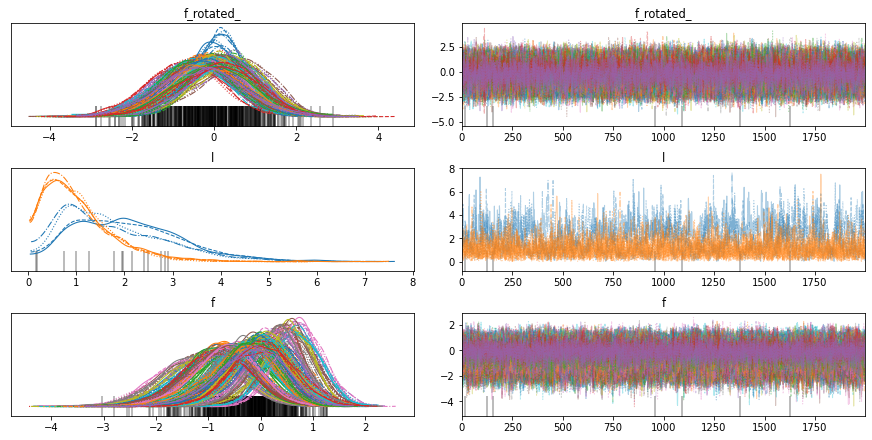

In [315]:
with model_part:
    pm.traceplot(trace_part);

In [316]:
pm.summary(trace_part, var_names=['~f_rotated_', '~f'])

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
l[0],1.924,1.131,0.110,3.910,0.065,0.046,305.0,305.0,282.0,912.0,1.03
l[1],1.034,0.748,0.025,2.349,0.011,0.009,4877.0,3619.0,4974.0,4117.0,1.00


In [317]:
with model_part:
    ppc = pm.sample_posterior_predictive(trace_part, 4000)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


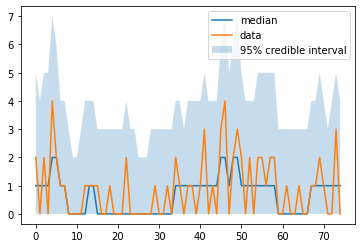

In [318]:
y_pred_q = np.percentile(ppc['obs'], axis=0, q=[2.5, 50, 97.5])
plt.plot(np.arange(n*3/4), y_pred_q[1], label='median')
plt.fill_between(np.arange(n*3/4), y_pred_q[0], y_pred_q[2],
                alpha=0.25, label='95% credible interval')
plt.plot(np.arange(n*3/4),y.T, label='data')
plt.legend()
plt.show()

We get an interesting result with this method the posterior looks really nice.

### Removing estimation of latent parameters

We are not interested in the latent process in the sense that we don't care about its parameters, we only care about forecasting. With that in mind we will discard the latent parameters such as $\ell$ and $\eta$ that describe the kernel. We do this because they are highly correlated with the GP process which means that it is hard to estimate. This will in theory simplify the MCMC.

In [322]:
with pm.Model() as model_part:
    #hyper-parameter priors
    #l = pm.Gamma('l', alpha=4, beta=1, shape=2)   
    #eta = pm.HalfCauchy('eta', beta=3)
    cov_func = pm.gp.cov.ExpQuad(2, ls=0.1*np.ones(2))

    gp = pm.gp.Latent(cov_func=cov_func)
    # initialize 20 inducing points with K-means
    # gp.util
    #Xu = pm.gp.util.kmeans_inducing_points(20, X)
    
    #Gaussian Process
    # reparameterize=True brings much more efficiency
    # see: https://sethrf.com/files/fast-hierarchical-GPs.pdf 
    # section 4.7
    f = gp.prior('f', X, reparameterize=True)
    
    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y.flatten())

In [324]:
with model_part:
    trace_part = pm.sample(draws=2000, 
                  tune=4000, 
                  init="advi+adapt_diag",
                  target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


Convergence achieved at 5900
Interrupted at 5,899 [2%]: Average Loss = 109.72
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 11 seconds.


In [330]:
with model_part:
    ppc = pm.sample_posterior_predictive(trace_part, 4000)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


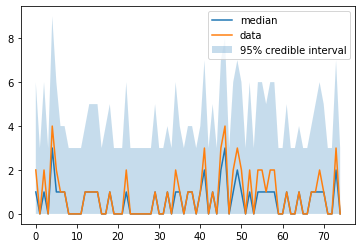

In [340]:
y_pred_q = np.percentile(ppc['obs'], axis=0, q=[2.5, 50, 97.5])
plt.plot(np.arange(n*(3/4)), y_pred_q[1], label='median')
plt.fill_between(np.arange(n*(3/4)), y_pred_q[0], y_pred_q[2],
                alpha=0.25, label='95% credible interval')
plt.plot(np.arange(n*(3/4)),y.T, label='data')
plt.legend()
plt.show()

# Sparse approximation

This model creates a covariance matrix with $N \times S$, with $N$ denoting the number of time points off all time series and $S$ the number of time series. In this section we look at some methods that could help to reduce this complexity. Defining additionally locations of inducing points (denoted Xu). It accepts the argument sigma instead of noise because these sparse approximations assume white IID noise.

### Using K-means to define inducing points

### Optimizing inducing point locations as part of the model

In [2]:
import numpy as np

In [1]:
S_obs = np.hstack(data.sig)
grp = data.group.values
n_grps = len(set(grp))
n_pts = data.sig.map(len)
rxn = np.hstack([int(i)*np.ones(n, dtype=int) for i,n in enumerate(n_pts)])
n_rxns = len(set(rxn))
t = np.hstack(data.time)

dim2_lst = np.sort(list(set(dim2)))[:,None]
dim2_idx = [list(dim2_lst).index(v) for v in dim2]
dim2_new = np.linspace(dim2_lst.min()-0.25,dim2_lst.max()+0.25,100)[:,None]


NameError: name 'np' is not defined